<a href="https://colab.research.google.com/github/SergeyPishchulov/CurrencyConverter/blob/main/Logica_Final_Exam_by_%D0%A1%D0%B5%D1%80%D0%B3%D0%B5%D0%B9_%D0%9F%D0%B8%D1%89%D1%83%D0%BB%D0%BE%D0%B2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logic Programming for Data Analysis 2021: Final Exam

`Сергей Пищулов`

`spishulov@gmail.com`

Original data sources:
* https://www.kaggle.com/kenshoresearch/kensho-derived-wikimedia-data
* https://www.kaggle.com/wosaku/crime-in-vancouver


In [1]:
!git clone https://github.com/evgskv/logica
from logica import colab_logica

Cloning into 'logica'...
remote: Enumerating objects: 1610, done.
remote: Counting objects: 100% (802/802), done.
remote: Compressing objects: 100% (555/555), done.
remote: Total 1610 (delta 493), reused 379 (delta 225), pack-reused 808
Receiving objects: 100% (1610/1610), 3.87 MiB | 11.48 MiB/s, done.
Resolving deltas: 100% (932/932), done.


In [2]:
%load_ext google.colab.data_table

In [3]:
!gdown https://drive.google.com/uc?id=1sPVUx7LzqofzvEdcB-9JUX4qlrqW7gbe
!unzip showbiz_and_vancouver.zip

Downloading...
From: https://drive.google.com/uc?id=1sPVUx7LzqofzvEdcB-9JUX4qlrqW7gbe
To: /content/showbiz_and_vancouver.zip
100% 25.3M/25.3M [00:00<00:00, 154MB/s]
Archive:  showbiz_and_vancouver.zip
replace showbusiness.db? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: showbusiness.db         
replace vancouver_crime.db? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: vancouver_crime.db      


In [24]:
print(["Award" for i in range(1,7)])

['Award', 'Award', 'Award', 'Award', 'Award', 'Award']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at SomeMovies_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

SELECT
  db_movie.*
FROM
  db.movie AS db_movie LIMIT 10;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at SomePeople_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

SELECT
  db_person.*
FROM
  db.person AS db_person LIMIT 10;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at SomeRockBands_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

SELECT
  db_rockband.*
FROM
  db.rockband AS db_rockband LIMIT 10;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at SomeAwards_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

SELECT
  db_award.*
FROM
  db.award AS db_award LIMIT 10;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at ShowbusinessStats_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

SELECT
  (SELECT
  SUM(MagicalEntangle(1, x_4.value)) AS logica_value
FROM
  db.movie AS db_movie, JSON_EACH(JSON_ARRAY(0)) as x_4) AS num_movies,
  (SELECT
  SUM(MagicalEntangle(1, x_6.value)) AS logica_value
FROM
  db.person AS db_person, JSON_EACH(JSON_ARRAY(0)) as x_6) AS num_people,
  (SELECT
  SUM(MagicalEntangle(1, x_8.value)) AS logica_value
FROM
  db.rockband AS db_rockband, JSON_EACH(JSON_ARRAY(0)) as x_8) AS num_bands;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at RockArtistInMovie_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

DROP TABLE IF EXISTS logica_test.RockArtist;
CREATE TABLE logica_test.RockArtist AS SELECT
  x_8.value AS person_id
FROM
  db.rockband AS db_rockband, JSON_EACH(db_rockband.members) as x_8
GROUP BY x_8.value;

-- Interacting with table logica_test.RockArtist

SELECT
  x_4.value AS person_id,
  db_movie.name AS movie
FROM
  db.movie AS db_movie, logica_test.RockArtist AS RockArtist, JSON_EACH(db_movie.casting) as x_4
WHERE
  (RockArtist.person_id = x_4.value)
GROUP BY x_4.value, db_movie.name;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at RockBandCastedInMovies_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

DROP TABLE IF EXISTS logica_test.RockArtist;
CREATE TABLE logica_test.RockArtist AS SELECT
  x_16.value AS person_id
FROM
  db.rockband AS t_0_db_rockband, JSON_EACH(t_0_db_rockband.members) as x_16
GROUP BY x_16.value;

-- Interacting with table logica_test.RockArtist

DROP TABLE IF EXISTS logica_test.RockArtistInMovie;
CREATE TABLE logica_test.RockArtistInMovie AS SELECT
  x_12.value AS person_id,
  db_movie.name AS movie
FROM
  db.movie AS db_movie, logica_test.RockArtist AS RockArtist, JSON_EACH(db_movie.casting) as x_12
WHERE
  (RockArtist.person_id = x_12.value)
GROUP BY x_12.value, db_movie.name;

-- Interacting with table logica_test.RockArtistInMovie

SELECT
  db_rockband.band_id AS rockband_id,
  db_rockband.name AS rockband_name,
  DistinctListAgg(RockArtistInMovie.movie) AS movies
FROM
  db.rockband AS db_rockband, logica

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at RockBandMovies_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

DROP TABLE IF EXISTS logica_test.RockArtist;
CREATE TABLE logica_test.RockArtist AS SELECT
  x_22.value AS person_id
FROM
  db.rockband AS t_1_db_rockband, JSON_EACH(t_1_db_rockband.members) as x_22
GROUP BY x_22.value;

-- Interacting with table logica_test.RockArtist

DROP TABLE IF EXISTS logica_test.RockArtistInMovie;
CREATE TABLE logica_test.RockArtistInMovie AS SELECT
  x_18.value AS person_id,
  db_movie.name AS movie
FROM
  db.movie AS db_movie, logica_test.RockArtist AS RockArtist, JSON_EACH(db_movie.casting) as x_18
WHERE
  (RockArtist.person_id = x_18.value)
GROUP BY x_18.value, db_movie.name;

-- Interacting with table logica_test.RockArtistInMovie

WITH t_0_RockBandCastedInMovies AS (SELECT
  db_rockband.band_id AS rockband_id,
  db_rockband.name AS rockband_name,
  DistinctListAgg(RockArtistInMovie.movie) AS movies
FROM
  db.roc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at MockMedalistTest_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

DROP TABLE IF EXISTS logica_test.Circle_f1;
CREATE TABLE logica_test.Circle_f1 AS WITH t_3_MockMovie AS (SELECT * FROM (
  
    SELECT
      'MovieWih_A' AS name,
      JSON_ARRAY('A') AS casting
   UNION ALL
  
    SELECT
      'MovieWih_B' AS name,
      JSON_ARRAY('B') AS casting
   UNION ALL
  
    SELECT
      'MovieWih_C' AS name,
      JSON_ARRAY('C') AS casting
  
) AS UNUSED_TABLE_NAME  )
SELECT * FROM (
  
    SELECT
      x_30.value AS person1_id,
      x_31.value AS person2_id
    FROM
      t_3_MockMovie AS MockMovie, JSON_EACH(MockMovie.casting) as x_30, JSON_EACH(MockMovie.casting) as x_31
    WHERE
      (x_30.value != x_31.value)
   UNION ALL
  
    SELECT
      x_35.value AS person1_id,
      x_36.value AS person2_id
    FROM
      db.rockband AS db_rockband, JSON_EACH(db_rockband.members) as x_35, JSON_EACH(db_rockband.m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at MockAward_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

SELECT * FROM (
  
    SELECT
      x_2.value AS awardee_id,
      x_3.value AS award
    FROM
      JSON_EACH(JSON_ARRAY('A', 'C', 'D')) as x_2, JSON_EACH(JSON_ARRAY('Award 1', 'Award 2', 'Award 3', 'Award 4', 'Award 5', 'Award 6')) as x_3
   UNION ALL
  
    SELECT
      'B' AS awardee_id,
      'Only B''s award 1' AS award
   UNION ALL
  
    SELECT
      'B' AS awardee_id,
      'Only B''s award 2' AS award
  
) AS UNUSED_TABLE_NAME  ;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at MedalistCountTest_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

DROP TABLE IF EXISTS logica_test.Circle_f1;
CREATE TABLE logica_test.Circle_f1 AS WITH t_4_MockMovie AS (SELECT * FROM (
  
    SELECT
      'MovieWih_A' AS name,
      JSON_ARRAY('A') AS casting
   UNION ALL
  
    SELECT
      'MovieWih_B' AS name,
      JSON_ARRAY('B') AS casting
   UNION ALL
  
    SELECT
      'MovieWih_C' AS name,
      JSON_ARRAY('C') AS casting
  
) AS UNUSED_TABLE_NAME  )
SELECT * FROM (
  
    SELECT
      x_30.value AS person1_id,
      x_31.value AS person2_id
    FROM
      t_4_MockMovie AS MockMovie, JSON_EACH(MockMovie.casting) as x_30, JSON_EACH(MockMovie.casting) as x_31
    WHERE
      (x_30.value != x_31.value)
   UNION ALL
  
    SELECT
      x_35.value AS person1_id,
      x_36.value AS person2_id
    FROM
      db.rockband AS db_rockband, JSON_EACH(db_rockband.members) as x_35, JSON_EACH(db_rockband.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at OnlyThreeMedalistsTest_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

DROP TABLE IF EXISTS logica_test.Circle_f1;
CREATE TABLE logica_test.Circle_f1 AS WITH t_5_MockMovie AS (SELECT * FROM (
  
    SELECT
      'MovieWih_A' AS name,
      JSON_ARRAY('A') AS casting
   UNION ALL
  
    SELECT
      'MovieWih_B' AS name,
      JSON_ARRAY('B') AS casting
   UNION ALL
  
    SELECT
      'MovieWih_C' AS name,
      JSON_ARRAY('C') AS casting
  
) AS UNUSED_TABLE_NAME  )
SELECT * FROM (
  
    SELECT
      x_32.value AS person1_id,
      x_33.value AS person2_id
    FROM
      t_5_MockMovie AS MockMovie, JSON_EACH(MockMovie.casting) as x_32, JSON_EACH(MockMovie.casting) as x_33
    WHERE
      (x_32.value != x_33.value)
   UNION ALL
  
    SELECT
      x_37.value AS person1_id,
      x_38.value AS person2_id
    FROM
      db.rockband AS db_rockband, JSON_EACH(db_rockband.members) as x_37, JSON_EACH(db_rock

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at AIsMedalistTest_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

DROP TABLE IF EXISTS logica_test.Circle_f1;
CREATE TABLE logica_test.Circle_f1 AS WITH t_4_MockMovie AS (SELECT * FROM (
  
    SELECT
      'MovieWih_A' AS name,
      JSON_ARRAY('A') AS casting
   UNION ALL
  
    SELECT
      'MovieWih_B' AS name,
      JSON_ARRAY('B') AS casting
   UNION ALL
  
    SELECT
      'MovieWih_C' AS name,
      JSON_ARRAY('C') AS casting
  
) AS UNUSED_TABLE_NAME  )
SELECT * FROM (
  
    SELECT
      x_34.value AS person1_id,
      x_35.value AS person2_id
    FROM
      t_4_MockMovie AS MockMovie, JSON_EACH(MockMovie.casting) as x_34, JSON_EACH(MockMovie.casting) as x_35
    WHERE
      (x_34.value != x_35.value)
   UNION ALL
  
    SELECT
      x_39.value AS person1_id,
      x_40.value AS person2_id
    FROM
      db.rockband AS db_rockband, JSON_EACH(db_rockband.members) as x_39, JSON_EACH(db_rockband.me

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at BIsNotMedalistTest_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

DROP TABLE IF EXISTS logica_test.Circle_f1;
CREATE TABLE logica_test.Circle_f1 AS WITH t_4_MockMovie AS (SELECT * FROM (
  
    SELECT
      'MovieWih_A' AS name,
      JSON_ARRAY('A') AS casting
   UNION ALL
  
    SELECT
      'MovieWih_B' AS name,
      JSON_ARRAY('B') AS casting
   UNION ALL
  
    SELECT
      'MovieWih_C' AS name,
      JSON_ARRAY('C') AS casting
  
) AS UNUSED_TABLE_NAME  )
SELECT * FROM (
  
    SELECT
      x_34.value AS person1_id,
      x_35.value AS person2_id
    FROM
      t_4_MockMovie AS MockMovie, JSON_EACH(MockMovie.casting) as x_34, JSON_EACH(MockMovie.casting) as x_35
    WHERE
      (x_34.value != x_35.value)
   UNION ALL
  
    SELECT
      x_39.value AS person1_id,
      x_40.value AS person2_id
    FROM
      db.rockband AS db_rockband, JSON_EACH(db_rockband.members) as x_39, JSON_EACH(db_rockband

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at BsAwardsInCircleAwardsOfA_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

DROP TABLE IF EXISTS logica_test.Circle_f1;
CREATE TABLE logica_test.Circle_f1 AS WITH t_4_MockMovie AS (SELECT * FROM (
  
    SELECT
      'MovieWih_A' AS name,
      JSON_ARRAY('A') AS casting
   UNION ALL
  
    SELECT
      'MovieWih_B' AS name,
      JSON_ARRAY('B') AS casting
   UNION ALL
  
    SELECT
      'MovieWih_C' AS name,
      JSON_ARRAY('C') AS casting
  
) AS UNUSED_TABLE_NAME  )
SELECT * FROM (
  
    SELECT
      x_32.value AS person1_id,
      x_33.value AS person2_id
    FROM
      t_4_MockMovie AS MockMovie, JSON_EACH(MockMovie.casting) as x_32, JSON_EACH(MockMovie.casting) as x_33
    WHERE
      (x_32.value != x_33.value)
   UNION ALL
  
    SELECT
      x_37.value AS person1_id,
      x_38.value AS person2_id
    FROM
      db.rockband AS db_rockband, JSON_EACH(db_rockband.members) as x_37, JSON_EACH(db_r

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

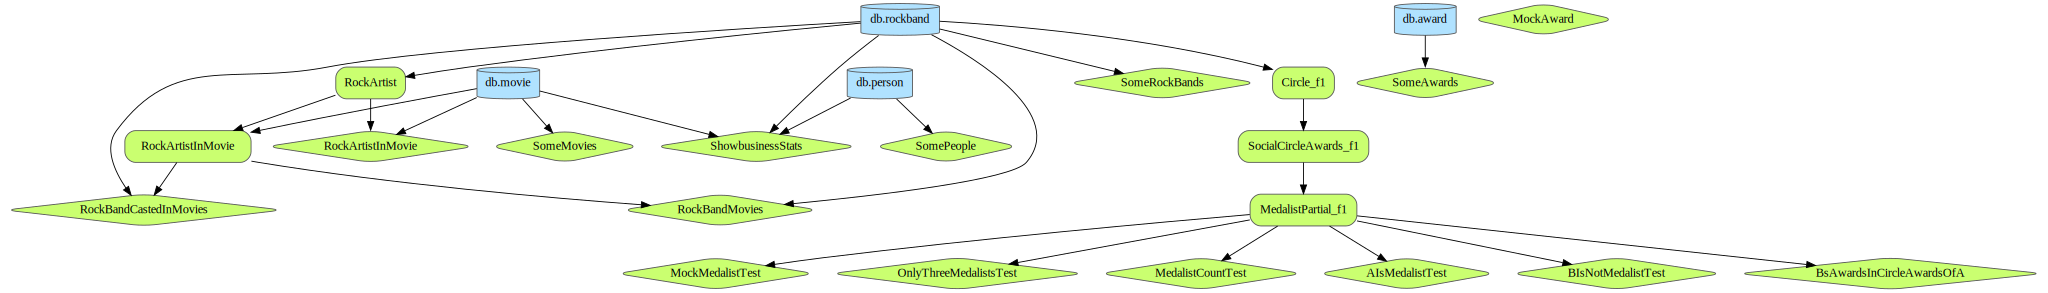

Running predicate: SomeRockBands (0 seconds)
Running predicate: SomeAwards (0 seconds)
Running predicate: Circle_f1 (0 seconds)
Running predicate: MockAward (0 seconds)
Running predicate: SomePeople (0 seconds)
Running predicate: RockArtist (0 seconds)
Running predicate: SomeMovies (0 seconds)
Running predicate: RockArtistInMovie (0 seconds)
Running predicate: ⤓RockArtistInMovie (0 seconds)
Running predicate: SocialCircleAwards_f1 (0 seconds)
Running predicate: ShowbusinessStats (0 seconds)
Running predicate: MedalistPartial_f1 (0 seconds)
Running predicate: MockMedalistTest (0 seconds)
Running predicate: OnlyThreeMedalistsTest (0 seconds)
Running predicate: MedalistCountTest (0 seconds)
Running predicate: RockBandCastedInMovies (0 seconds)
Running predicate: RockBandMovies (0 seconds)
Running predicate: AIsMedalistTest (0 seconds)
Running predicate: BIsNotMedalistTest (0 seconds)
Running predicate: BsAwardsInCircleAwardsOfA (0 seconds)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at SomeMovies variable.


,movie_id,name,casting
0,10449147,Chez nous,[458752]
1,1764347,SOS – en segelsällskapsresa,"[458752,714141,5961246,1770250,3372998,5627798]"
2,517239,The Big Blue,"[524544,551683,89130,109232,484779,3898080,436..."
3,4004228,A Perfect Family,"[524544,468793,241154,3846163,3734264,450442,2..."
4,25460,36 Views from the Pic Saint-Loup,"[524544,212873,2848242,441071,923461,3559331]"
5,2943857,Va savoir,"[524544,298905,3740386,543898,531256,923461,11..."
6,586569,The Star Maker,"[524544,2437312,983069,3905249,3945964,684794,..."
7,2927272,Brief Encounters,"[512,435805,4400363]"
8,4444445,Стряпуха,"[512,4429200,1750617]"
9,6461073,La Bailanta,"[5833472,439182,5475691,22122546,16527966,2942..."


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at SomePeople variable.


,person_id,name,citizenships
0,877041,Elanne Kong,"[""People's Republic of China""]"
1,58314,Maxim Gvinjia,"[""Russia""]"
2,1936098,Mimmo Poli,"[""Italy"",""Kingdom of Italy""]"
3,2209514,Sabin Tambrea,"[""Germany"",""Romania""]"
4,3446441,Ruba Blal,"[""Israel""]"
5,3077378,Pim de la Parra,"[""Suriname"",""Kingdom of the Netherlands""]"
6,71698,Katrin Saß,"[""German Democratic Republic"",""Germany""]"
7,6520861,Leleti Khumalo,"[""South Africa""]"
8,54957869,Salon Basnet,"[""Nepal""]"
9,73945,Hendrik Duryn,"[""German Democratic Republic"",""Germany""]"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at SomeRockBands variable.


,band_id,name,members
0,16821277,Alice Cooper,"[332032,2313011,427302,665549,2720155]"
1,728707,Noir Désir,"[3479552,3022539,545516,3168680]"
2,205001,Talking Heads,"[336640,2695530,438635,2634067]"
3,182890,Def Leppard,"[511488,323356,1143956,1336388,10699937,367617..."
4,1850330,The Walkmen,[17037824]
5,7737085,The Golden Palominos,[589313]
6,1544817,The Feelies,"[589313,5568993]"
7,261,Linkin Park,"[19202,19198,19200,19205,19204,19199,19201]"
8,807957,Barclay James Harvest,[153346]
9,773640,Apocalypse,[2252546]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at SomeAwards variable.


,awardee_id,awardee_name,award
0,4724516,Ali,Filmfare Awards South
1,4724516,Ali,Nandi Award for Best Male Comedian
2,232449,BoA,Mnet Asian Music Award for Best New Artist
3,20729,Cro,2013 Echo Awards
4,20729,Cro,Swiss Music Awards 2013
5,20729,Cro,1 Live Krone
6,20729,Cro,Bambi Award
7,154543,D12,MTV Europe Music Award for Best Hip-Hop
8,239464,Eve,Grammy Award for Best Rap/Sung Performance
9,6480008,Lal,Kerala State Film Award for Best Actor


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at ShowbusinessStats variable.


,num_movies,num_people,num_bands
0,110475,105982,728


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at RockArtistInMovie variable.


,person_id,movie
0,633,'68
1,633,CSNY/Déjà Vu
2,633,Human Highway
3,633,Journey Through the Past
4,633,Love at Large
...,...,...
1056,16099557,Underground
1057,16099557,"Vukovar, jedna priča"
1058,19967341,Flamenco
1059,21642482,Dwellers


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at RockBandCastedInMovies variable.


,rockband_id,rockband_name,movies
0,261,Linkin Park,"[""Saw 3D"", ""Crank"", ""Artifact"", ""Crank: High V..."
1,396,U2,"[""Entropy"", ""Dancing Barefoot"", ""Pavarotti"", ""..."
2,1299,The Beatles,"[""Forrest Gump"", ""Steve Jobs"", ""Lisztomania"", ..."
3,2306,Pink Floyd,"[""The Strat Pack"", ""Soundbreaking"", ""Roger Wat..."
4,2331,Led Zeppelin,"[""Animal Rage"", ""Son of Dracula"", ""Blowup"", ""C..."
...,...,...,...
190,19922002,Saint Asonia,"[""Raise Your Voice""]"
191,23772001,Got7,"[""A Stray Goat""]"
192,24075465,Steve Taylor & The Perfect Foil,"[""Social Intercourse""]"
193,25706903,The Dynamic Rockers,"[""Key Exchange"", ""The Rock"", ""Hiding Out"", ""Al..."


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at RockBandMovies variable.


,rockband_id,rockband_name,movies
0,261,Linkin Park,"[""Saw 3D"", ""Crank"", ""Artifact"", ""Crank: High V..."
1,396,U2,"[""Entropy"", ""Dancing Barefoot"", ""Pavarotti"", ""..."
2,1299,The Beatles,"[""Forrest Gump"", ""Steve Jobs"", ""Lisztomania"", ..."
3,2306,Pink Floyd,"[""The Strat Pack"", ""Soundbreaking"", ""Roger Wat..."
4,2331,Led Zeppelin,"[""Animal Rage"", ""Son of Dracula"", ""Blowup"", ""C..."
...,...,...,...
723,24567008,Dogs of Peace,[]
724,867531,Circa,[]
725,571303,Lady Pank,[]
726,2279110,3 (American Band),[]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at MockMedalistTest variable.


,person_name,person_id,number_of_awards,awards,social_circle_awards


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at MockAward variable.


,awardee_id,award
0,A,Award 1
1,A,Award 2
2,A,Award 3
3,A,Award 4
4,A,Award 5
5,A,Award 6
6,C,Award 1
7,C,Award 2
8,C,Award 3
9,C,Award 4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at MedalistCountTest variable.


,logica_value
0,None


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at OnlyThreeMedalistsTest variable.


,logica_value
0,Fail


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at AIsMedalistTest variable.


,logica_value
0,Fail


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at BIsNotMedalistTest variable.


,logica_value
0,Pass


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at BsAwardsInCircleAwardsOfA variable.


,logica_value


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
%%logica SomeMovies, SomePeople, SomeRockBands, SomeAwards, ShowbusinessStats,RockArtistInMovie, RockBandCastedInMovies, RockBandMovies, MockMedalistTest, MockAward, MedalistCountTest, OnlyThreeMedalistsTest, AIsMedalistTest, BIsNotMedalistTest, BsAwardsInCircleAwardsOfA


@Engine("sqlite");
@AttachDatabase("db", "showbusiness.db");

@Limit(SomeMovies, 10);
SomeMovies(..r) :- db.movie(..r);

@Limit(SomePeople, 10);
SomePeople(..r) :- db.person(..r);

@Limit(SomeRockBands, 10);
SomeRockBands(..r) :- db.rockband(..r);

@Limit(SomeAwards, 10);
SomeAwards(..r) :- db.award(..r);

ShowbusinessStats(num_movies:,
                  num_people:,
                  num_bands:) :-
  num_movies += (1 :- db.movie()),
  num_people += (1 :- db.person()),
  num_bands += (1 :- db.rockband());

#TODO Проверить на всех non-distinct предикатах, влияет ли на них distinct.
#TODO вызвать все предикаты.

#1
LordOfRock(person_id:, person_name:) distinct :- 
  db.award(awardee_id:person_id, awardee_name:person_name, award:"Order of the British Empire"),
  db.award(awardee_id:person_id, awardee_name:person_name, award:"Rock and Roll Hall of Fame");

#2
JuniorOrderMember(person_id:, person_name:) distinct :-
  db.award(awardee_id:person_id, awardee_name:person_name, award:"Order of the British Empire"),
  ~db.award(awardee_id:person_id, awardee_name:person_name, award:"Commander of the Order of the British Empire");

#3 TODO
ProminentSovietArtist(person_id:, person_name:) distinct :- 
  db.award(awardee_id:person_id, awardee_name:person_name, award:"USSR State Prize") | 
  db.award(awardee_id:person_id, awardee_name:person_name, award:"People's Artist of the USSR");

#4
BillAndCharlieButNotKevin(award:) distinct :- 
  db.award(awardee_name:"Bill Gates", award:),
  db.award(awardee_name:"Charlie Chaplin", award:),
  ~db.award(awardee_name:"Kevin Spacey", award:);

#5
RussianRockArtist(person_id:, person_name:) :- db.person(person_id:, name:person_name, citizenships:),
  "Russia" in citizenships, RockArtist(person_id:);

@Ground(RockArtist); 
RockArtist(person_id:) distinct :- db.rockband(members:), person_id in members;

#6
RockBandMovies(rockband_id:, rockband_name:, movies:) :- 
  RockBandCastedInMovies(rockband_id:, rockband_name:, movies:);
RockBandMovies(rockband_id:, rockband_name:, movies:[]) :- 
  db.rockband(band_id:rockband_id, name:rockband_name), ~RockBandCastedInMovies(rockband_id:);

RockBandCastedInMovies(rockband_id:, rockband_name:, movies? Set=movie) distinct :-
  db.rockband(band_id:rockband_id, name:rockband_name, members:),
  member in members, 
  RockArtistInMovie(person_id:member, movie:);

@Ground(RockArtistInMovie); 
RockArtistInMovie(person_id:, movie:movie_name) distinct:- 
  db.movie(name:movie_name, casting:), person_id in casting, RockArtist(person_id:);

#7
Medalist(person_name:, person_id:, number_of_awards:, awards:, social_circle_awards:) distinct :-
  MedalistPartial(person_name:, person_id:, awards:, social_circle_awards:),
  number_of_awards == Size(awards),
  number_of_awards > 5;

@Ground(MedalistPartial); 
MedalistPartial(person_name:, person_id:, awards? List= award, social_circle_awards:) distinct :-
  db.person(person_id:, name:person_name),
  db.award(awardee_id:person_id, award:),
  SocialCircleAwards(person_id:, friends_awards:social_circle_awards);

@Ground(SocialCircleAwards); 
SocialCircleAwards(person_id:, friends_awards? Set= friend_award) distinct :-
  Circle(person1_id:person_id, person2_id:friend_id),
  db.award(awardee_id:friend_id, award:friend_award);

@Ground(Circle); 
Circle(person1_id:, person2_id:) :- db.movie(casting:),
  person1_id in casting, 
  person2_id  in casting,
  person1_id != person2_id;
Circle(person1_id:, person2_id:) :- db.rockband(members:),
  person1_id in members, 
  person2_id  in members,
  person1_id != person2_id;

Flatten(list_of_lists) = r :- r List= x, x in xs, xs in list_of_lists;
# Unique(l) = r :- r Set= x, x in l;

#8 TODO: D не снимался ни в одном фильме. Почему он не может быть medalist'ом?
MockPerson(person_id:"A", name:"A");
MockPerson(person_id:"B", name:"B");
MockPerson(person_id:"C", name:"C");
MockPerson(person_id:"D", name:"D");


MockAward(awardee_id:, award:) :- awardee_id in ["A", "C", "D"], 
  award in ["Award 1", "Award 2", "Award 3", "Award 4", "Award 5", "Award 6"]; 


MockAward(awardee_id:"B", award:"Only B's award 1");#не должен попасть в Medalist
MockAward(awardee_id:"B", award:"Only B's award 2");#эти нагарады должны попасть в social_circle_awards of A

MockMovie(name:"MovieWih_A_and_B", casting:["A", "B", "C"]);
MockMovie(name:"MovieWih_A", casting:["A"]);
MockMovie(name:"MovieWih_B", casting:["B"]);
MockMovie(name:"MovieWih_C", casting:["C"]);

MockMedalistTest := Medalist(db.person: MockPerson, db.award: MockAward, db.movie: MockMovie);
MedalistCountTest() +=1 :- MockMedalistTest(); 
OnlyThreeMedalistsTest() =  if (MedalistCountTest() == 3) then "Pass" else "Fail";
AIsMedalistTest() = if ("A" in medalists) then "Pass" else "Fail" :- medalists List= (person_name :- MockMedalistTest(person_name:));
BIsNotMedalistTest() = if ("B" in medalists) then "Fail" else "Pass" :- medalists List= (person_name :- MockMedalistTest(person_name:));
BsAwardsInCircleAwardsOfA() = if ("Only B's award 1" in circle_of_a) then "Pass" else "Fail" :- MockMedalistTest(person_name:"A", social_circle_awards:circle_of_a);

#9 TODO записей примерно на 1000 меньше чем фильмов. Кажется, не все актеры есть в persons
@Ground(CitizenshipsInMovies); 
CitizenshipsInMovies(movie_id:, movie_name:, citizenships? Set= x) distinct :-
  db.movie(movie_id:, name:movie_name, casting:),
  person_id in casting,
  person(person_id:, citizenships:person_citizenships),
  all_persons_citizenships List= person_citizenships,
  x in Flatten(all_persons_citizenships);

AukusMovie(movie_id:, movie_name:, citizenships:) :-
  CitizenshipsInMovies(movie_id:, movie_name:, citizenships:),
  "Australia" in citizenships,
  "United Kingdom" in citizenships,
  "United States of America" in citizenships;

#10
@Ground(CastTogether); 
CastTogether(x, y, movie:name) :- db.movie(casting:, name:),
  x in casting, 
  y  in casting,
  x != y;
@Ground(VysotskyId); 
VysotskyId() = person_id :- db.person(person_id:, name:"Vladimir Vysotsky");
@Ground(SchwarzeneggerId);
SchwarzeneggerId() = person_id :- db.person(person_id:, name:"Arnold Schwarzenegger");

@Ground(PathTo); 
@Recursive(PathTo, 3);
PathTo(VysotskyId()) ArgMin= [VysotskyId()] -> 0;
PathTo(y) ArgMin= path -> Size(path) :-
 PathTo(x) == path_to_x,
 CastTogether(x, y),
 path == ArrayConcat(path_to_x, [y]);


@Ground(OnlyPath); 
OnlyPath() =  PathTo(SchwarzeneggerId());
PathFromVladimirToArnold(step_number:i+1, from_person:, to_person:, movie:) :-
  i in Range(Size(path) - 1),
  from_person_id == Element(path, i),
  to_person_id == Element(path, i+1),
  path == OnlyPath(),
  MovieLink(from_person_id, to_person_id, movies:),
  movie == Element(movies, 0),
  db.person(person_id:from_person_id, name:from_person),
  db.person(person_id:to_person_id, name:to_person);


MovieLink(x, y, movies? List=movie) distinct :- CastTogether(x, y, movie:);


@Ground(GurchenkoId); 
GurchenkoId() = person_id :- db.person(person_id:, name:"Lyudmila Gurchenko");
@Ground(MonroeId);
MonroeId() = person_id :- db.person(person_id:, name:"Marilyn Monroe");

PathFromLyudmilaToMarilyn := PathFromVladimirToArnold(VysotskyId:GurchenkoId, SchwarzeneggerId: MonroeId );


In [ ]:
%%logica SomeCrime, NumCrimes, CrimeCountAtHour, CrimeAtHour, NeighbourhoodCrimeDistribution, CrimeChangeExpanded, MostVolatileType, CrimeChange

@Engine("sqlite");
@AttachDatabase("db", "vancouver_crime.db");

@Limit(SomeCrime, 10);
SomeCrime(..r) :- db.crime(..r);

NumCrimes() += 1 :- db.crime();

#11
CrimeAtHour(hour:, crimetype? ArgMax= crimetype -> count ) distinct :- CrimeCountAtHour(hour:, crimetype:, count:);

CrimeCountAtHour(hour:, crimetype:, count? +=1) distinct :- db.crime(hour:, crimetype:);

#12
NeighbourhoodCrimeDistribution(neighbourhood:, crimes? List= {crimetype:, proportion:}) distinct :-
  proportion == CrimetypeProportionInNeighbourhood(neighbourhood:, crimetype:);

CrimetypeProportionInNeighbourhood(neighbourhood:, crimetype:) = ToFloat64(count)/all_crimes_in_nei :-
  count == CrimesCountInNeighbourhood(neighbourhood:, crimetype:),
  all_crimes_in_nei == AllCrimesCountInNeighbourhood(neighbourhood:);

CrimesCountInNeighbourhood(neighbourhood:, crimetype:) +=1 :- db.crime(neighbourhood:, crimetype:);

@Ground(AllCrimesCountInNeighbourhood);
AllCrimesCountInNeighbourhood(neighbourhood:) += CrimesCountInNeighbourhood(neighbourhood:, crimetype:);

#TODO delete
CheckPerc(neighbourhood:, r? += proportion) distinct :- 
  proportion == CrimetypeProportionInNeighbourhood(neighbourhood:, crimetype:);

  
Abs(x) = if x > 0 then x else -1*x;
#13
CrimeChange(year:, crimetype:, changed_from:, changed_to:) :- 
  MostVolatileType(year:, crimetype:),
  CrimeChangeExpanded(year:, crimetype:, changed_from:, changed_to:);

MostVolatileType(year:, crimetype? ArgMax= ct -> delta) distinct :- 
  CrimeChangeExpanded(year:, crimetype:ct, changed_from:, changed_to:, delta:);

CrimeChangeExpanded(year:this_year, crimetype:, changed_from:prev_count, changed_to:cur_count, delta:):-
  cur_count == CrimeCountByYear(year:this_year, crimetype:),
  prev_count == CrimeCountByYear(year:this_year - 1, crimetype:),
  delta == Abs(cur_count - prev_count);

@Ground(CrimeCountByYear);
CrimeCountByYear(year:, crimetype:) += 1 :- db.crime(year:, crimetype:);

In [ ]:
%%logica Fibonacci

@Engine("sqlite");

#14
Fibonacci(number_index:0, number_value:0);
Fibonacci(number_index:1, number_value:1);

Fibonacci(number_index:, number_value:prev+prev_prev) :- 
  Fibonacci(number_index:number_index-1, number_value:prev),
  Fibonacci(number_index:number_index-2, number_value:prev_prev),
  number_index in Range(10),
  number_index > 1;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at Word_sql variable.
SELECT * FROM (
  
    SELECT
      '20211212' AS col0
   UNION ALL
  
    SELECT
      'neveragain' AS col0
   UNION ALL
  
    SELECT
      'civil' AS col0
   UNION ALL
  
    SELECT
      'abbaforever' AS col0
   UNION ALL
  
    SELECT
      'taxxataxxazere' AS col0
   UNION ALL
  
    SELECT
      'aba' AS col0
   UNION ALL
  
    SELECT
      'abaxxxx' AS col0
   UNION ALL
  
    SELECT
      'abba' AS col0
   UNION ALL
  
    SELECT
      'xxxx' AS col0
  
) AS UNUSED_TABLE_NAME  ;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at Palindrome_sql variable.
WITH t_0_Word AS (SELECT * FROM (
  
    SELECT
      '20211212' AS col0
   UNION ALL
  
    SELECT
      'neveragain' AS col0
   UNION ALL
  
    SELECT
      'civil' AS col0
   UNION ALL
  
    SELECT
      'abbaforever' AS col0
   UNION ALL
  
    SELECT
      'taxxataxxazere' AS col0
   UNION ALL
  
    SELECT
      'aba' AS col0
   UNION ALL
  
    SELECT
      'abaxxxx' AS col0
   UNION ALL
  
    SELECT
      'abba' AS col0
   UNION ALL
  
    SELECT
      'xxxx' AS col0
  
) AS UNUSED_TABLE_NAME  ),
t_1_EqualLettersInWord AS (SELECT
  t_2_Word.col0 AS word,
  JSON_GROUP_ARRAY(SUBSTR(t_2_Word.col0, ((x_5.value) + (1)), 1)) AS fs
FROM
  t_0_Word AS t_2_Word, JSON_EACH((select json_group_array(n) from (with recursive t as(select 0 as n union all select n + 1 as n from t where n + 1 < ((LENGTH(t_2_Word.col0)) / (2))) select n from t) where n < ((LENGTH(t_2_Word.col0)) / (2)))) as x_5
WHERE
  (SUBSTR(t_2_Word.col0, ((x_5.valu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at PalindromeDecomposition_sql variable.
WITH t_3_Word AS (SELECT * FROM (
  
    SELECT
      '20211212' AS col0
   UNION ALL
  
    SELECT
      'neveragain' AS col0
   UNION ALL
  
    SELECT
      'civil' AS col0
   UNION ALL
  
    SELECT
      'abbaforever' AS col0
   UNION ALL
  
    SELECT
      'taxxataxxazere' AS col0
   UNION ALL
  
    SELECT
      'aba' AS col0
   UNION ALL
  
    SELECT
      'abaxxxx' AS col0
   UNION ALL
  
    SELECT
      'abba' AS col0
   UNION ALL
  
    SELECT
      'xxxx' AS col0
  
) AS UNUSED_TABLE_NAME  ),
t_4_EqualLettersInWord AS (SELECT
  t_5_Word.col0 AS word,
  JSON_GROUP_ARRAY(SUBSTR(t_5_Word.col0, ((x_30.value) + (1)), 1)) AS fs
FROM
  t_3_Word AS t_5_Word, JSON_EACH((select json_group_array(n) from (with recursive t as(select 0 as n union all select n + 1 as n from t where n + 1 < ((LENGTH(t_5_Word.col0)) / (2))) select n from t) where n < ((LENGTH(t_5_Word.col0)) / (2)))) as x_30
WHERE
  (SUBSTR(t_5_Word.c

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

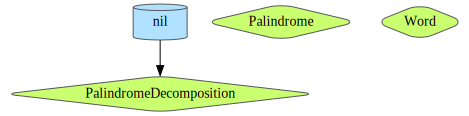

Running predicate: Palindrome (0 seconds)
Running predicate: Word (0 seconds)
Running predicate: PalindromeDecomposition (0 seconds)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at Word variable.


,col0
0,20211212
1,neveragain
2,civil
3,abbaforever
4,taxxataxxazere
5,aba
6,abaxxxx
7,abba
8,xxxx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at Palindrome variable.


,word
0,aba
1,abba
2,xxxx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at PalindromeDecomposition variable.


,word,parts
0,aba,"[""aba""]"
1,abaxxxx,"[""aba"", ""xxxx""]"
2,abba,"[""abba""]"
3,xxxx,"[""xxxx""]"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
%%logica Word, Palindrome, PalindromeDecomposition

@Engine("sqlite");
Word("20211212");
Word("neveragain");
Word("civil");
Word("abbaforever");
Word("taxxataxxazere");

Word("aba");
Word("abaxxxx");
Word("abba");
Word("xxxx");

#15 TODO превратить ее в функцию от любых парметров, чтобы не было требования  Word(w)
# PalindromeDecomposition(word:w, parts:3) :- Word(w), Palindrome(word:w);
@Recursive(PalindromeDecomposition, 8);
PalindromeDecomposition(word:w, parts? ArgMin= [w] -> 1) distinct :- Word(w), Palindrome(word:w);

# PalindromeDecomposition(word:w, parts? ArgMin= solve -> Size(solve), solve:) distinct :- Word(w), first_part_len in Range(Length(w)), first_part_len > 0,
#   solve1==[first_part], first_part == Substr(w, 1, first_part_len),
#   solve2==[second_part], second_part == Substr(w, first_part_len+1, Length(w)-first_part_len),
#   solve == ArrayConcat(solve1, solve2);


PalindromeDecomposition(word:w, parts? ArgMin= solve -> Size(solve)) distinct :- Word(w), first_part_len in Range(Length(w)), first_part_len > 0,
  PalindromeDecomposition(word:first_part, parts:solve1), first_part == Substr(w, 1, first_part_len),
  PalindromeDecomposition(word:second_part, parts:solve2), second_part == Substr(w, first_part_len+1, Length(w)-first_part_len),
  solve == ArrayConcat(solve1, solve2);

Palindrome(word:) :- Word(word), EqualLettersInWord(word:, fs:), Size(fs)==Length(word)/2;
EqualLettersInWord(word:, fs? List= f) distinct :- i in Range(Length(word)/2),# fs - список символов из левой половины слова, которая имеют такие же символы в правой половине.
  f==Substr(word, i+1, 1), l == Substr(word, Length(word)-i, 1),f==l, Word(word);

